# Project #3 : Collaboration and Competition

## DDPG Training Algorithm

---

This notebook implements my solution for the Continous Control project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

I implemented the Deep Deterministic Policy Gradient (DDPG) training algorithm for the Unity Reacher environment.

The code in this notebook (Continuous_Control.ipynb), the ddpg_agent.py, and model.py files is derived from the 'ddpg-pendulum' code example used in the nanodegree program. The code was modified to successfully train both the single agent and multiple agents version of the the Unity Reacher environment. The code also implements the logic to stop the training when the environment is considered solved. The project requirement is to reach an average score of 30, measured over the last 100 training episodes. In the case of the multiple agents version, the episode score is the mean of the agents' scores of the episode.

### 1. Install Python Packages

If you haven't done so already, run this command to install a few packages in your computing environment.  This line may take a few minutes to run!

In [1]:
#!pip -q install ./python

### 2. Import libraries

In [2]:
import torch
import numpy as np
from collections import deque
import time

from unityagents import UnityEnvironment
from maddpg_agent import MADDPG_Agent


   *****************
   *** Using CPU ***
   *****************



### 3. Instantiate the Unity Tennis environment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
# on my iMac 
env = UnityEnvironment(file_name="Tennis.app")

# in my Udacity Workspace
#env = UnityEnvironment(file_name='/data/Tennis_Linux/Tennis.x86_64')

# on my AWS instance
#env = UnityEnvironment(file_name='./Tennis_Linux/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment and activate the training mode
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents    :', num_agents)

# action size
action_size = brain.vector_action_space_size
print('Size of each action : ', action_size)

# state size
states = env_info.vector_observations
state_size = states.shape[1]
print('Size of each state  :', state_size)

Number of agents    : 2
Size of each action :  2
Size of each state  : 24


### 4. Instantiate the Agent

In [5]:
# set the agent and model hyperparameters

class Config():
    def __init__(self):
        self.SEED = 31415            # seed for random number generator
        self.PRINT_EVERY = 100       # number of episodes after which the training procedures prints out a persistent update

        self.TARGET_SCORE = 0.5      # target score; training is complete when target score is met
        self.WINDOW_SIZE = 100       # number of episodes over which the average episode score is calculated
        
        self.BUFFER_SIZE = int(1e6)  # replay buffer size
        self.BATCH_SIZE = 128        # minibatch size

        self.LR_ACTOR = 1e-4         # learning rate of the actor 
        self.LR_CRITIC = 5e-4        # learning rate of the critic

        self.LEARN_EVERY = 1         # learning timestep interval
        self.LEARN_NUM = 1           # number of learning passes
        
        self.GAMMA = 0.99            # reward discount factor
        self.TAU = 0.05              # soft update of target parameters

        self.ADD_NOISE = True        # if True, Ornstein-Uhlenbeck Noise is added to actions
        self.OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter volatility
        self.OU_THETA = 0.12         # Ornstein-Uhlenbeck noise parameter speed of mean reversion
        self.EPS_INITIAL = 5.5       # initial value of epsilon in Ornstein-Uhlenbeck noise process
        self.EPS_TERMINAL = 0        # terminal value of epsilon in Ornstein-Uhlenbeck noise process
        self.EPS_DECAY = 250         # number of episodes over which epsilon decays in OU noise process

        self.FC1_UNITS_ACTOR = 256   # number of nodes in Actor's first fully connected layer
        self.FC2_UNITS_ACTOR = 128   # number of nodes in Actor's second fully connected layer
        self.FCS1_UNITS_CRITIC = 256 # number of nodes in Critic's first fully connected layer
        self.FC2_UNITS_CRITIC = 128  # number of nodes in Critic's second fully connected layer

config = Config()

In [6]:
# initialize agents
agent_0 = MADDPG_Agent(state_size, action_size, 1, config)
agent_1 = MADDPG_Agent(state_size, action_size, 1, config)

### 5. Train the Agent

In [7]:
# Training Routine

def train_agent(n_episodes, max_t, train_mode, config):
    """Run training process
    
    Arguments:
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        config (dict)   : the agent and neural network hyperparamters

    """

    scores = []                                # container for all episode scores
    scores_deque = deque(maxlen = config.WINDOW_SIZE) # deque for episode scores in sliding window
    moving_average_scores = []                 # container for the moving average scores 
    best_score = -np.Inf                       # the highest moving average score achieved
    start_time =  time.time()                  # start time, required to calculate the total training time
    environment_solved = False                 # True when TARGET_SCORE is reached and environment is solved
    solved_episode = 0                         # episode in which environment is solved

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]   # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        player_scores = np.zeros(num_agents)
        t = 0
        while t < max_t:
            '''gets actions for each agent and then combines them into one array'''
            a0 = agent_0.act(states, config.ADD_NOISE)           # agent 0 chooses an action
            a1 = agent_1.act(states, config.ADD_NOISE)           # agent 1 chooses an action
            actions = np.concatenate((a0, a1), axis=0).flatten() # combine agent actions
            env_info = env.step(actions)[brain_name]             # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                           # get reward
            dones = env_info.local_done                          # see if episode finished
            agent_0.step(states, actions, rewards[0], next_states, dones, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, dones, 1) # agent 2 learns
            player_scores += rewards                             # update the score for each player
            t += 1
            states = next_states                                 # roll over states to next time step
            if np.any(dones):                                    # exit loop if episode finished
                break

        # calculate the episode score: best player's score
        episode_score = np.max(player_scores)

        # update the sliding window of episode scores
        scores_deque.append(episode_score)

        # append the average episode score to the scores array 
        scores.append(episode_score)

        # update and store the average sliding score
        moving_average_score = np.mean(scores_deque)
        moving_average_scores.append(moving_average_score)

        # update time the training process has lasted thus far, in minutes
        training_time = time.time() - start_time

        # after each episode, update the printout of the episode and sliding average scores
        print('\rEpisode {:}\tScore: {:.3f}\tMoving Score: {:.3f}\tClock: {}'
            .format(i_episode,\
                    episode_score,\
                    moving_average_score,\
                    int(training_time)),\
                    end="")

        # after every PRINT_EVERY episode, print the sliding average score
        if i_episode % config.PRINT_EVERY == 0:
            print('\rEpisodes {:3}-{:3}\tMax: {:.3f}\tMoving Average: {:.3f}\tClock: {}'
            .format(i_episode-config.PRINT_EVERY,\
                    i_episode,\
                    max(scores[-config.PRINT_EVERY:]),\
                    moving_average_score,\
                    int(training_time)))
            
        # determine if environment is solved
        if (not environment_solved) and (moving_average_score >= config.TARGET_SCORE):
            print('\n--> Environment Solved in {:d} episodes!'.format(i_episode - config.WINDOW_SIZE))
            environment_solved = True
            solved_episode = i_episode
            
        # save the model weights if the average episode score improved
        if (environment_solved) and (i_episode >= config.WINDOW_SIZE) and (episode_score > best_score):
            # update best_score
            best_score = episode_score
            # save weights
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')

    # determine if environment is solved
    if (not environment_solved):
        print('\nCould not solve the environment')
    else:
        print('\nEnvironment Solved in {:d} episodes !'.format(solved_episode))     
            
    return scores, moving_average_scores

In [8]:
# run the training loop
n_episodes = 1500
max_t = 1000
train_mode = True

scores, moving_average_scores = train_agent(n_episodes, max_t, train_mode, config)

Episodes   0-100	Max: 0.100	Moving Average: 0.002	Clock: 23
Episodes 100-200	Max: 0.200	Moving Average: 0.007	Clock: 49
Episodes 200-300	Max: 0.200	Moving Average: 0.016	Clock: 79
Episodes 300-400	Max: 0.300	Moving Average: 0.038	Clock: 117
Episodes 400-500	Max: 0.200	Moving Average: 0.060	Clock: 163
Episodes 500-600	Max: 0.900	Moving Average: 0.099	Clock: 238
Episodes 600-700	Max: 2.000	Moving Average: 0.206	Clock: 379
Episodes 700-800	Max: 2.600	Moving Average: 0.208	Clock: 521
Episodes 800-900	Max: 2.600	Moving Average: 0.207	Clock: 664
Episodes 900-1000	Max: 1.600	Moving Average: 0.199	Clock: 802
Episodes 1000-1100	Max: 1.400	Moving Average: 0.138	Clock: 892
Episodes 1100-1200	Max: 2.600	Moving Average: 0.245	Clock: 1063
Episodes 1200-1300	Max: 2.600	Moving Average: 0.197	Clock: 1205
Episodes 1300-1400	Max: 2.600	Moving Average: 0.340	Clock: 1462
Episode 1489	Score: 0.400	Moving Score: 0.500	Clock: 1832
--> Environment Solved in 1389 episodes!
Episodes 1400-1500	Max: 2.600	Moving A

In [9]:
env.close()

### 6. Plot and save the Training Curve

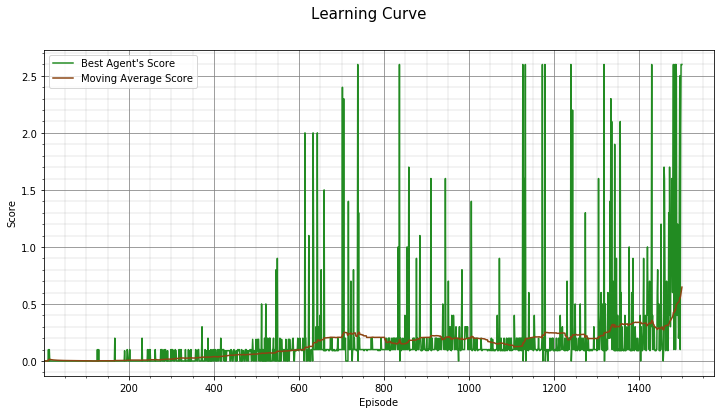

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Learning Curve", fontsize=15)

ax.plot(np.arange(1, len(scores)+1), scores, color="forestgreen", label="Best Agent's Score")
ax.plot(np.arange(1, len(scores)+1), moving_average_scores, color="saddlebrown", label="Moving Average Score")
plt.xlim(left=1)
#plt.ylim(bottom=-1)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(True)
ax.grid(b=True, which='major', color='gray', linestyle='-', linewidth=0.75)
ax.minorticks_on()
ax.grid(b=True, which='minor', color='gray', linestyle='-', alpha=.75, linewidth=0.25)
plt.legend(loc='upper left')
plt.show()

#  save plot to a file
fig.savefig("learning_curve1.jpg")